In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from HelperFunctions import *
from PtOccupancyFunctions import *
import io

In [2]:
def getData(directory):
    end_time = 24 * 3600  # 24 hours
    for sdir_path, sdir in [
        (sdir.path, sdir.name) for sdir in os.scandir(directory) if sdir.is_dir()
    ]:
        for root, subdirs, files in os.walk(sdir_path):
            for file in files:
                if file == "output_trips.csv.gz":
                    df_trips = pd.read_csv(
                        os.path.join(root, file), sep=";", compression="gzip"
                    ).loc[
                        :,
                        [
                            "person",
                            "dep_time",
                            "trav_time",
                            "wait_time",
                            "traveled_distance",
                            "modes",
                        ],
                    ]
                    df_trips["dep_time"] = df_trips["dep_time"].apply(timestmp2sec)
                    df_trips = df_trips[df_trips["dep_time"] < end_time]
                    df_trips["trav_time"] = df_trips["trav_time"].apply(timestmp2sec)
                    df_trips["wait_time"] = df_trips["wait_time"].apply(timestmp2sec)
                    df_trips.set_index("person", inplace=True)
                if file == "0.drt_trips_drt.csv":
                    df_drt = pd.read_csv(os.path.join(root, file), sep=";").loc[
                        :,
                        [
                            "departureTime",
                            "personId",
                            "waitTime",
                            "travelDistance_m",
                            "direcTravelDistance_m",
                        ],
                    ]
                    df_drt = df_drt[df_drt["departureTime"] < end_time]
                    df_drt = df_drt.groupby("personId").sum()
                if file == "0.drt_occupancy_time_profiles_drt.txt":
                    df_drt_occ = pd.read_csv(os.path.join(root, file), sep="\t")
                    df_drt_occ["time"] = df_drt_occ["time"].apply(timestmphm2sec)
                    df_drt_occ = df_drt_occ[df_drt_occ["time"] < end_time]
                if file == "0.occupancyAnalysis.txt":
                    df_pt_occ = getPtOccupancies(os.path.join(root, file), 540)
                    df_pt_occ = df_pt_occ[:end_time]
                if file == "trip_success.csv":
                    df_serv = pd.read_csv(
                        os.path.join(root, file), sep=";", header=None
                    )
                    servability = len(df_serv[df_serv[1]]) / len(df_serv)
                if file == "0.vehicleDistanceStats_drt.csv":
                    df_drt_cars = pd.read_csv(os.path.join(root, file), sep=";")[
                        ["drivenDistance_m", "occupiedDistance_m"]
                    ]

        yield int(
            sdir
        ), df_trips, df_drt, df_drt_occ, df_pt_occ, servability, df_drt_cars

In [3]:
def getAverageOcc(df, exclude_empty_vehicles=False):
    if exclude_empty_vehicles == True:
        df.drop(columns=["STAY", "0 pax"], inplace=True)
        weights = np.arange(1, len(df.columns) + 1)
    else:
        weights = np.zeros(len(df.columns))
        weights[1:] = np.arange(0, len(df.columns) - 1)

    pass_sum = df.sum(axis=1)
    mean = (df.dot(weights) / pass_sum).mean()
    s = (df.to_numpy() * (weights - mean) ** 2).sum(axis=1) / (pass_sum - 1)
    return mean, np.sqrt(s).mean()

In [4]:
path = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/"

count = 0
vehicle_list = []
av_drt_occs = []
av_pt_occs = []
av_detours = []
total_dists = []
servabilities = []
for (
    vehicles,
    df_trips,
    df_drt_trips,
    df_occ_drt,
    df_occ_pt,
    servability,
    df_drt_cars,
) in getData(path):
    print("Number of vehicles: ", vehicles)
#     df_trips = df_trips.groupby("person").agg(
#         {
#             "dep_time": lambda x: x.iloc[0],
#             "trav_time": np.sum,
#             "wait_time": np.sum,
#             "traveled_distance": np.sum,
#             "modes": combineModesSeriesStr,
#         }
#     )
    vehicle_list.append(vehicles)
    drt_occ, drt_deviation = getAverageOcc(
        df_occ_drt.drop(columns="time"), exclude_empty_vehicles=True
    )
    av_drt_occs.append([drt_occ, drt_deviation])
    av_detours.append(
        (
            df_drt_trips["travelDistance_m"] / df_drt_trips["direcTravelDistance_m"]
        ).mean()
    )
    # total_dists.append(df_trips['traveled_distance'].sum())
    total_dists.append(df_drt_cars["drivenDistance_m"].sum())
    av_pt_occs.append(getAverageTimeSeries(df_occ_pt))
    servabilities.append(servability)

vehicle_list = np.array(vehicle_list)
idx = np.argsort(vehicle_list)
vehicle_list = vehicle_list[idx]
av_drt_occs = np.array(av_drt_occs)[idx]
av_pt_occs = np.array(av_pt_occs)[idx]
av_detours = np.array(av_detours)[idx]
total_dists = np.array(total_dists)[idx]
servabilities = np.array(servabilities)[idx]

Number of vehicles:  100
Number of vehicles:  110
Number of vehicles:  120
Number of vehicles:  130
Number of vehicles:  140
Number of vehicles:  150
Number of vehicles:  160
Number of vehicles:  170
Number of vehicles:  180
Number of vehicles:  190
Number of vehicles:  200
Number of vehicles:  210
Number of vehicles:  220
Number of vehicles:  230
Number of vehicles:  240
Number of vehicles:  250
Number of vehicles:  260
Number of vehicles:  270
Number of vehicles:  280
Number of vehicles:  290
Number of vehicles:  300
Number of vehicles:  310
Number of vehicles:  320
Number of vehicles:  330
Number of vehicles:  340
Number of vehicles:  350
Number of vehicles:  360
Number of vehicles:  370
Number of vehicles:  380
Number of vehicles:  390
Number of vehicles:  400
Number of vehicles:  50
Number of vehicles:  60
Number of vehicles:  70
Number of vehicles:  80
Number of vehicles:  90


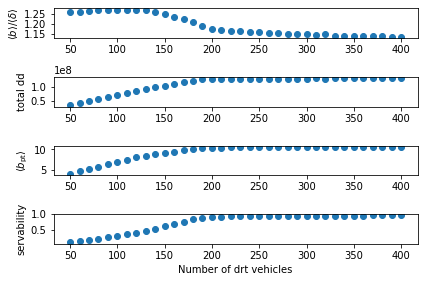

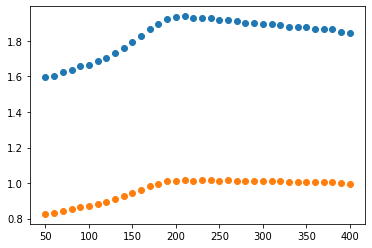

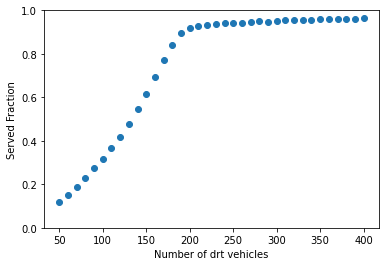

In [5]:
%matplotlib inline
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

ax1.scatter(vehicle_list, av_drt_occs[:,0]/av_detours)
ax1.set_ylabel(r'$\langle b\rangle / \langle\delta\rangle$')
# ax1.set_xlabel('Number of drt vehicles')
ax2.scatter(vehicle_list, total_dists)#/servabilities)
ax2.set_ylabel('total dd')
# ax2.set_xlabel('Number of drt vehicles')
ax3.scatter(vehicle_list, av_pt_occs)
ax3.set_ylabel(r'$\langle b_{\mathrm{pt}}\rangle$')
# ax3.set_xlabel('Number of drt vehicles')
ax4.scatter(vehicle_list, servabilities)
ax4.set_ylabel(r'servability')
ax4.set_xlabel('Number of drt vehicles')
fig.tight_layout()

# fig.savefig('OptDrtCount.png', dpi=200)
plt.figure()
plt.scatter(vehicle_list, av_drt_occs[:,0])
plt.scatter(vehicle_list, av_drt_occs[:,1])
plt.show()

fig, ax = plt.subplots()
ax.scatter(vehicle_list, servabilities)
ax.set_ylim(0,1)
ax.set_ylabel('Served Fraction')
ax.set_xlabel('Number of drt vehicles')

fig.savefig('Servabilities.png', dpi=200)

<IPython.core.display.Javascript object>


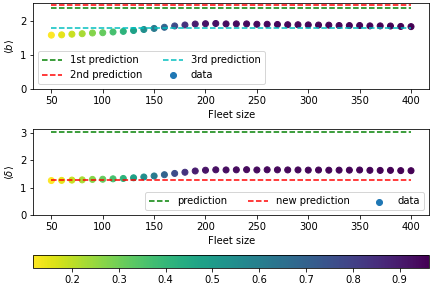

In [26]:
%matplotlib notebook

def b_av(b_max):
    alpha = 0.521 #Two rnd point difference
    beta = 0.383 #Rnd point to center
    return ((b_max - 1) * b_max / 2 * alpha / beta + b_max) / (
        (b_max - 1) * alpha / beta + 1
    )

def my_b_av(b_max):
    return (b_max+1)/2

def my_new_b_av(b_maxpool):
    beta = 0.383
    k = beta*np.sqrt(2)
    return -(b_maxpool*k**(b_maxpool+1)-(b_maxpool+1)*k**b_maxpool+1)/((k-1)*(1-k**b_maxpool))
#     return sum([i*(np.sqrt(2)*beta)**i for i in range(1,5)])/sum([(np.sqrt(2)*beta)**i for i in range(1,5)])


def delta_av(b_max):
    alpha = 0.521
    beta = 0.383
    return 1 + alpha / beta * (b_max - 1) / 2


def my_delta_av(delta_max, b_av):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    return np.exp(np.log(delta_bar) / np.log(2) * np.log((b_av + 1) / 2))


fig, (ax, ax1) = plt.subplots(2, 1, constrained_layout=True)

ax.scatter(vehicle_list, av_drt_occs[:, 0], label="data", c=servabilities, cmap='viridis_r')
# ax.scatter(vehicle_list, av_drt_occs[:, 0]/servabilities, label="data")
ax.plot(
    vehicle_list, [b_av(4) for _ in vehicle_list], ls="--", label="1st prediction", c="g"
)
ax.plot(
    vehicle_list, [my_b_av(4) for _ in vehicle_list], ls="--", label="2nd prediction", c="r"
)
ax.plot(
    vehicle_list, [my_new_b_av(4) for _ in vehicle_list], ls="--", label="3rd prediction", c="c"
)
ax.set_xlabel("Fleet size")
ax.set_ylabel(r"$\langle b\rangle$")
ax.set_ylim((0, None))
ax.legend(ncol=2)


im = ax1.scatter(vehicle_list, av_detours, label="data", c=servabilities, cmap='viridis_r') 
ax1.plot(
    vehicle_list,
    [delta_av(4) for _ in vehicle_list],
    ls="--",
    label="prediction",
    c="g",
)
# ax1.plot(vehicle_list, [my_delta_av(1.5, b_av(4)) for _ in vehicle_list], ls='--', label='new prediction', c='y')
ax1.plot(
    vehicle_list,
#     my_delta_av(1.5, av_drt_occs[:, 0]),
    [my_delta_av(1.5, 4) for _ in vehicle_list],
    ls="--",
    label="new prediction",
    c="r",
)
ax1.set_xlabel("Fleet size")
ax1.set_ylabel(r"$\langle\delta\rangle$")
ax1.set_ylim((0, None))
ax1.legend(ncol=3, loc='lower right')

fig.colorbar(im, ax=ax1, location='bottom')

# fig.tight_layout()
fig.savefig("Prediction_b_delta.png", dpi=200)
plt.show()